# 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

In [2]:
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [3]:
# Configure API key
quandl.ApiConfig.api_key = 'rdScvGQmKsbRycfK_dyF'

In [4]:
# Federal Reserve Economic Data - Medical care services for urban consumers
data = quandl.get('FRED/CUSR0000SAM2')

In [5]:
data.head(5)

,Value
Date,
1956-01-01,16.1
1956-02-01,16.0
1956-03-01,16.2
1956-04-01,16.2
1956-05-01,16.2


In [6]:
data.shape

(793, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

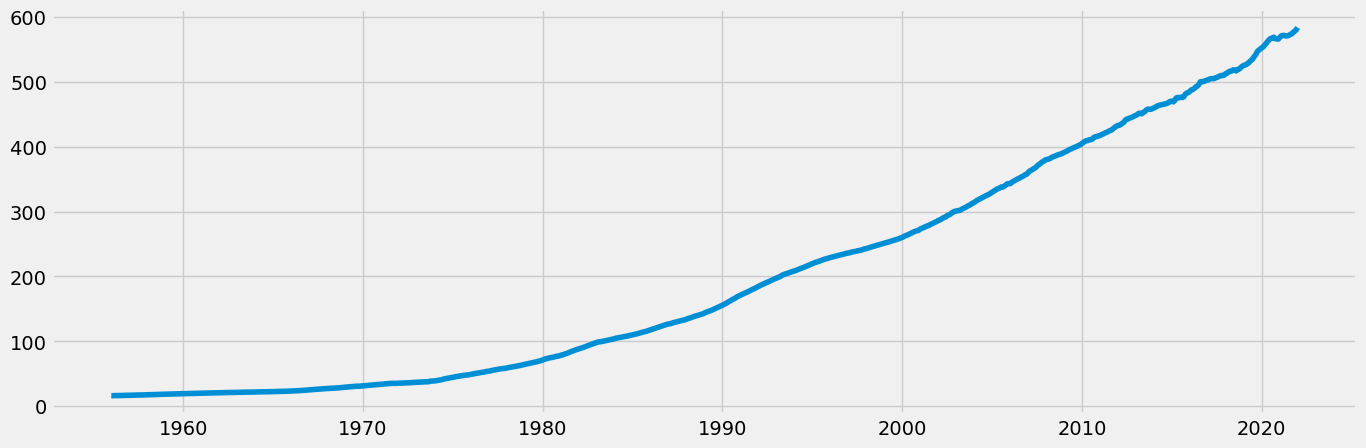

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. 
# When it's set to 100, it will produce lower-than-standard quality, which is useful if, similar to this notebook, 
# you'll have a lot of plots. A large number of plots will increase the size of the notebook, 
# which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# 2. Checking, subsetting and cleaning the data

In [9]:
# Check for missing values
data.isnull().sum() # There is no missing values

Value    0
dtype: int64

In [10]:
# Check for duplicates
data.duplicated().sum() # There is no diplicates 

55

In [12]:
# Resetting index to use the 'Date' column as a filter since the 'Date' column is setted as index.
data_2 = data.reset_index()

In [13]:
data_2.head()

,Date,Value
0,1956-01-01,16.1
1,1956-02-01,16.0
2,1956-03-01,16.2
3,1956-04-01,16.2
4,1956-05-01,16.2


In [14]:
# My original dataset for this achivement doesn't contain any date or time columns. However I would like to restrain the date of 'datawest' data between 2015 and 2021 
data_sub = data_2.loc[(data_2['Date']>= '2015-01-01') & (data_2['Date'] <= '2021-07-01')]

In [15]:
data_sub.shape

(79, 2)

In [16]:
data_sub.head()

,Date,Value
708,2015-01-01,470.198
709,2015-02-01,469.241
710,2015-03-01,471.460
711,2015-04-01,475.195
712,2015-05-01,475.984


In [17]:
# Set the 'Date' column as the index for the sub dataset.
from datetime import datetime
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis = 1, inplace = True) # Drop the 'Date' column.
data_sub.head(5)

,Value
datetime,
2015-01-01,470.198
2015-02-01,469.241
2015-03-01,471.460
2015-04-01,475.195
2015-05-01,475.984


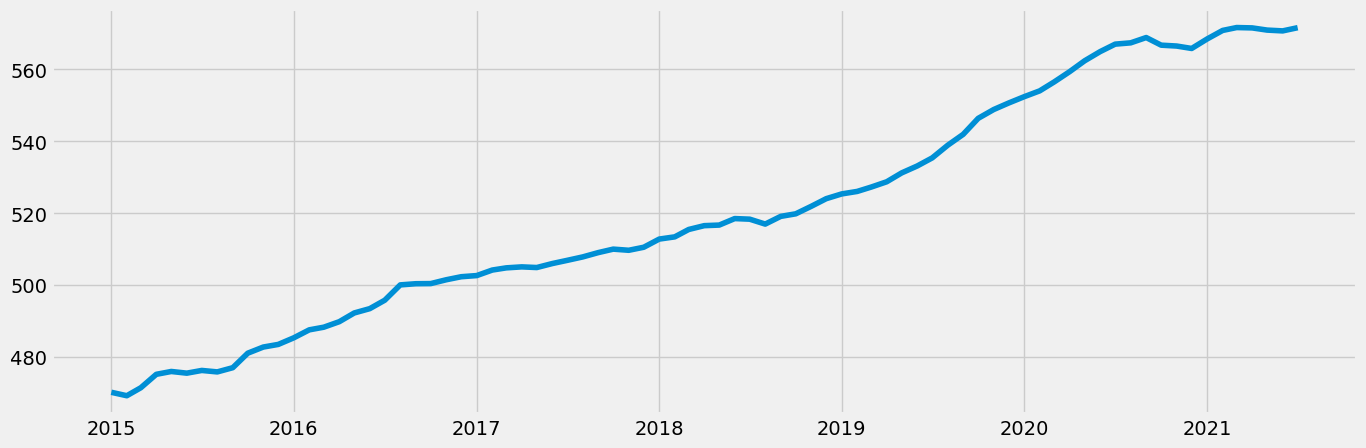

In [18]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [19]:
# Check for missing values
data_sub.isnull().sum() # no missing values

Value    0
dtype: int64

In [20]:
# Check for duplicates
data_sub.duplicated().sum() # No dups!

0

# 3. Time series analysis: decomposition

In [21]:
# Decompose the time series using additive model, since the cahnges in the data is linear.
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [22]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

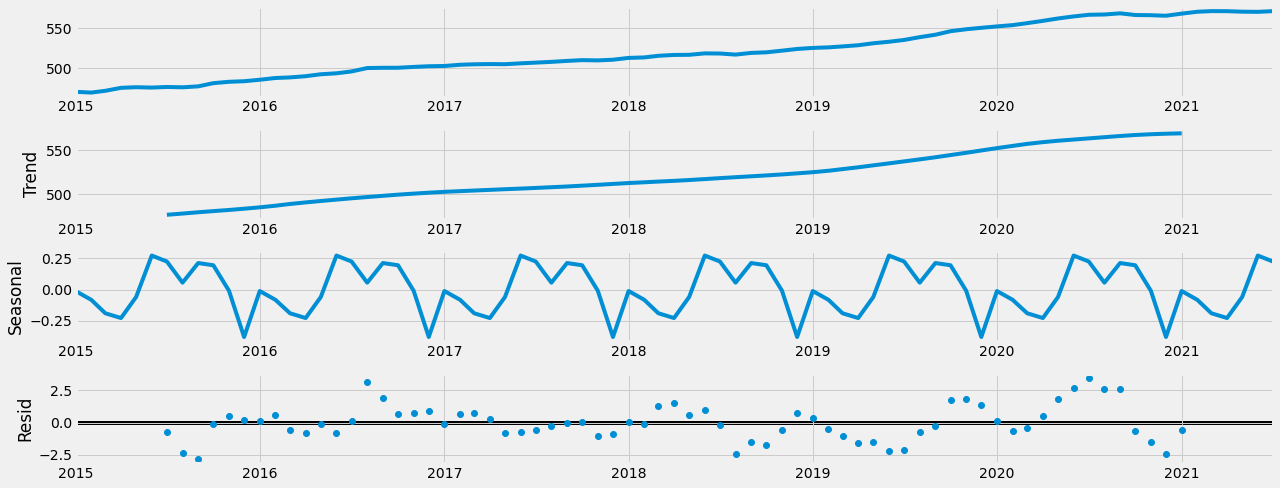

In [23]:
# Plot the separate components

decomposition.plot()
plt.show()

- The first line above is the data itself that called the level.
- The second is the underlying trend. th etrend line is very similar to level line, that is because there is not much noise in the data set.
- The third line shows seasonality. The pattern of curve repeats at a 1 year period.
- The last component is the noise. There is a few unexplained noise points.  

# 4.Testing for stationary

In [24]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.805447
p-value                         0.991724
Number of Lags Used            12.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


Since the test statistic is larger than the critical value, I can't reject null hypothesis. That means there is a unit root in my data and my data is non-stationary.

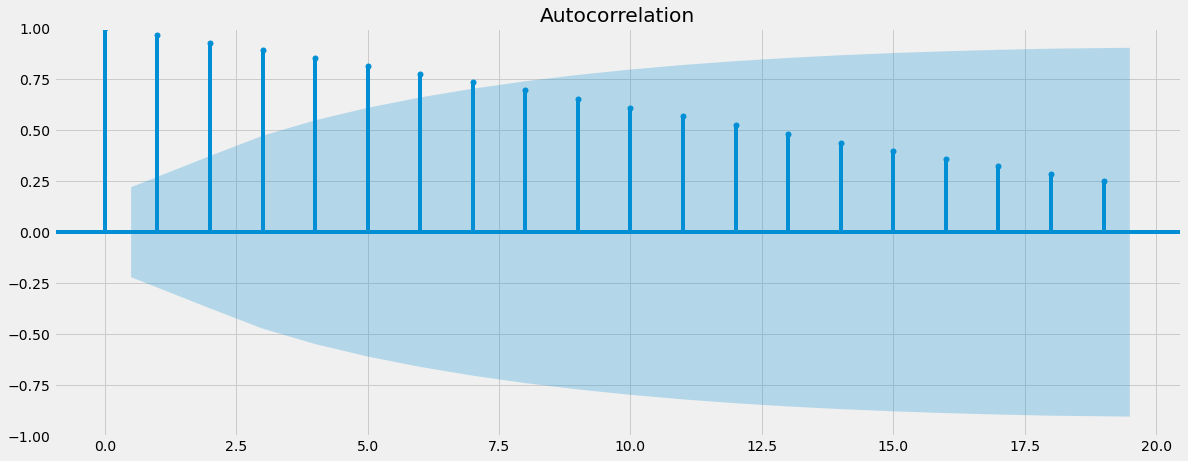

In [25]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means you have lags that are significantly correlated with each other. And when you have many lags beyond this interval, you can deduce that your data is non-stationary.

# 5. Stationarizing the Federal Reserve Economic Data

In [26]:
# Diffrencing method can be used to stationarize the data (value = t - (t-1))
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [28]:
# Dropping missing values that came about as a result of the differencing
data_diff.dropna(inplace = True)

In [29]:
data_diff.head()

,Value
datetime,
2015-02-01,-0.957
2015-03-01,2.219
2015-04-01,3.735
2015-05-01,0.789
2015-06-01,-0.468


In [31]:
data_diff.shape

(78, 1)

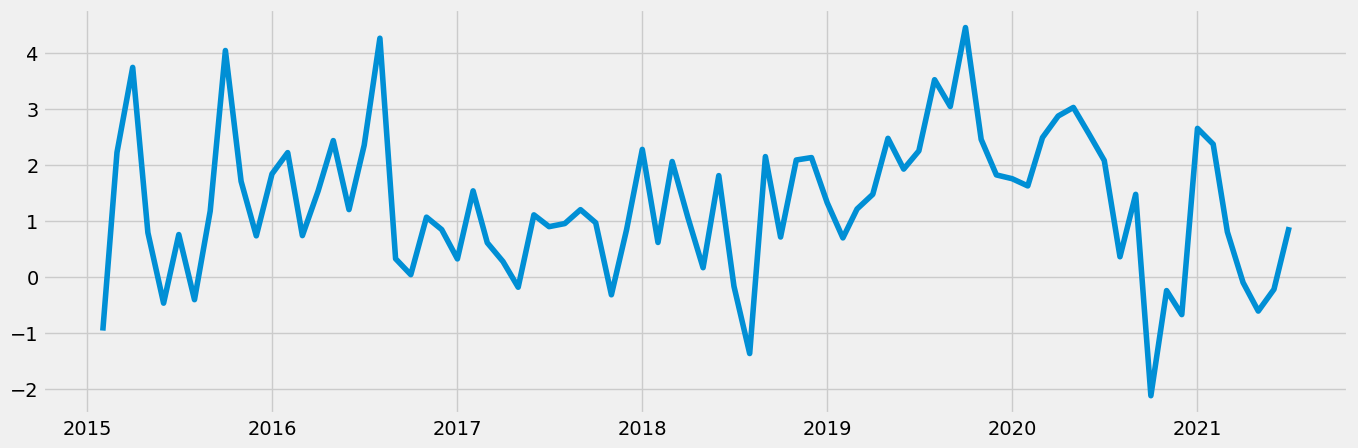

In [32]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

The values on the y-axis have changed greatly. Because data's trend is gotten rid of by stationarizing data.

In [33]:
# Now try to conduct the Dickey-Fuller test again.
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.289757
p-value                         0.015343
Number of Lags Used            11.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


The test statistic is smaller than the critical value at 5 nd 10 percent significant levels. And also, p-value is smaller than 0.05. That means I can reject the null hypothesis and consider the data series stationary.

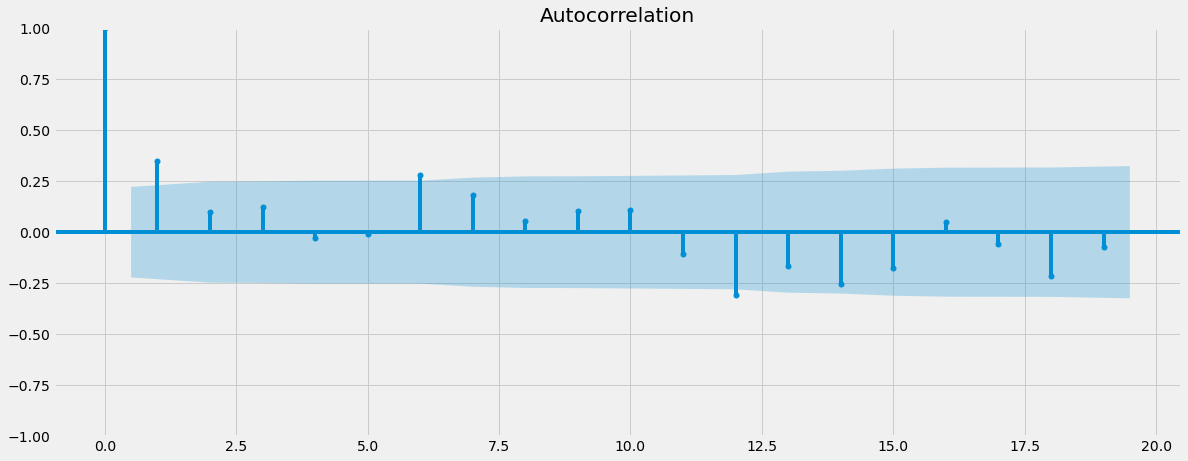

In [34]:
# Checking autocorrelations
plot_acf(data_diff)
plt.show()

The stationary I created is strong since the most lags in the correlation area. 